**Project:** Sentiment Analysis of [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

**Author:** [Giuseppe Muschetta](https://github.com/peppe212)

**Python version:** 3.8

## SENTIMENT ANALYSIS WITH DEEP LEARNING KERAS SEQUENTIAL API

In [1]:
# Ignoriamo i warnings
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# setto lo stile globale di matplotlib
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import seaborn as sns
# Stile globale seaborn
sns.set(
    style='whitegrid',
    palette='pastel',
    context='notebook',
    font_scale=1.1,
    rc={'lines.linewidth': 2, 'grid.linestyle': '--'}
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from keras.layers import (Embedding,
                          BatchNormalization,
                          Conv1D, 
                          Dense, 
                          Dropout, 
                          MaxPooling1D,
                          Bidirectional,
                          LSTM)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from gensim.models import Word2Vec

#### IMPOSTAZIONE DEI VARI PATH

In [2]:
# Caricamento del Dataset già processato e ripulito
DATASET_PATH = Path() / "Dataset/cleaned_reviews.csv"
df = pd.read_csv(DATASET_PATH)
if df.isna().any().any():
    df.fillna("", inplace=True)


# Gestione salvataggio immagini
IMAGES_PATH = Path() / "Images" / "Deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return
    
# Gestione salvataggio e caricamento del modello di deep learning
MODEL_PATH = Path() / "Saved_models" / "Deep"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Salva il modello su un file di estensione default.tf
def save_deep_model(model, model_name='deep_learning', model_extension="tf"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    try:
        model.save(path)
        print(f"Modello salvato correttamente in: {path}")
    except Exception as e:
        print(f"Si è verificato un errore durante il salvataggio del modello: {e}")
        raise FileNotFoundError
#end_function

# Carica il modello dal file con estensione a default.tf
def load_deep_model(model_name='deep_learning', model_extension="tf"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    if path.exists():
        try:
            model = load_model(path)
            print(f"Modello caricato correttamente da: {path}")
            return model
        except Exception as e:
            print(f"Si è verificato un errore durante il caricamento del modello: {e}")
            raise
    else:
        error_msg = f"Il file del modello non esiste: {path}"
        print(error_msg)
        raise FileNotFoundError(error_msg)
#end_function


# Gestione salvataggio e caricamento del modello di word2vec
WORD2VEC_PATH = Path() / "Saved_models" / "Word2Vec"
WORD2VEC_PATH.mkdir(parents=True, exist_ok=True)

# Salva il modello w2v su un file di estensione default.tf
def save_w2v_model(model, model_name='word2vec', model_extension="model"):
    path = WORD2VEC_PATH / f"{model_name}.{model_extension}"
    try:
        model.save(str(path))
        print(f"Modello word2vec salvato correttamente in: {path}")
    except Exception as e:
        print(f"Si è verificato un errore durante il salvataggio del modello word2vec: {e}")
        raise FileNotFoundError
#end_function

# Carica il modello w2v dal file con estensione a default.tf
def load_w2v_model(model_name='word2vec', model_extension="model"):
    path = WORD2VEC_PATH / f"{model_name}.{model_extension}"
    if path.exists():
        try:
            model = Word2Vec.load(str(path))
            print(f"Modello word2vec caricato correttamente da: {path}")
            return model
        except Exception as e:
            print(f"Si è verificato un errore durante il caricamento del modello word2vec: {e}")
            raise
    else:
        error_msg = f"Il file del modello word2vec non esiste: {path}"
        print(error_msg)
        raise FileNotFoundError(error_msg)
#end_function

#### PREPARAZIONE DEI DATI PER IL MODELLO DI DEEP LEARNING

In [3]:
# TRAIN VALID TEST SPLIT
# questa cella deve essere eseguita anche se si carica da file un modello già addestrato
X = df['cleaned_text'].values
y = df['sentiment'].values

# Divido i dati in training, validation e test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
# ADDESTRAMENTO DEL MODELLO WORD2VEC PER UN EMBEDDING PERSONALIZZATO
# Definisco la dimensione di embedding
EMBEDDING_SIZE = 128

# nel mio caso 10 perché avendo una CPU con 11 core ne ho lasciato 
# uno libero per le classiche operazioni di sistema e background
WORKERS = 10

# Il Word2Vec ha bisogno di una lista di liste di token
X_train_tokenized = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=EMBEDDING_SIZE, window=5, min_count=1, workers=WORKERS)
w2v_model.train(X_train_tokenized, total_examples=len(X_train_tokenized), epochs=10)

# Verifico del numero di vettori di parole nel modello
vocab_size_w2v = len(w2v_model.wv)
print(f"Word2Vec vocabulary size: {vocab_size_w2v}")

Word2Vec vocabulary size: 121726


#### Salvo il modello word2vec addestrato su file

In [5]:
# Salvo il modello w2v
save_w2v_model(w2v_model)

Modello word2vec salvato correttamente in: Saved_models/Word2Vec/word2vec.model


#### Carico il modello word2vec addestrato da file

In [4]:
w2v_model = load_w2v_model()

Modello word2vec caricato correttamente da: Saved_models/Word2Vec/word2vec.model


#### TOKENIZZAZIONE, MATRICE DI EMBEDDING

In [6]:
# Tokenizzazione
WORDS_TO_KEEP = 15000
tokenizer = Tokenizer(num_words=WORDS_TO_KEEP, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Parametri per configurare lo strato di embedding personalizzato
# questo parametro specifica la lunghezza della matrice di embedding
# settiamo il tutto pari alla dimensione totale del vocabolario
entire_vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {entire_vocab_size}")

# Creazione della matrice di embedding
embeddings_found = 0
embedding_matrix = np.zeros((WORDS_TO_KEEP + 1, EMBEDDING_SIZE))

for word, index in tokenizer.word_index.items():
    # Metto minore o uguale perché gli indici iniziano da 1
    if index <= WORDS_TO_KEEP: 
        if word in w2v_model.wv:
            embedding_vector = w2v_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
                embeddings_found += 1

# check matrix creation
if embeddings_found > 0:
    print(f"Embedding matrix created successfully. Words found in Word2Vec model: {embeddings_found}")
else:
    print("No embeddings found. Check the Word2Vec model or the tokenizer's word_index.")


# Trasformo i dati per renderli compatibili con l'input della rete neurale
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding delle sequenze
MAX_WORDS = 100 # una media delle parole contenute nelle 164000 recensioni amazon
X_train = pad_sequences(X_train, maxlen=MAX_WORDS, padding='post')
X_valid = pad_sequences(X_valid, maxlen=MAX_WORDS, padding='post')
X_test  = pad_sequences(X_test, maxlen=MAX_WORDS, padding='post')

# Controllo la distribuzione delle classi
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Distribuzione delle classi nel training set:", class_distribution)

Vocabulary size: 102269
Embedding matrix created successfully. Words found in Word2Vec model: 14587
Distribuzione delle classi nel training set: {0: 65604, 1: 65655}


## Architecture of the Neural Network

This model is designed as a sequential model with multiple layers, each tailored to process and learn from textual data effectively:

### Embedding Layer
- **Input Dimension**: Set to `vocab_size`, covering the entire vocabulary.
- **Output Dimension**: Defined by `embedding_size`, determining the size of the embedding vectors.
- **Weights**: Initialized with a pre-trained `embedding_matrix` to leverage prior knowledge.
- **Trainable**: Set to `True`, allowing the embeddings to update during training.
- **Mask Zero**: Enables the layer to ignore padded zeros in sequences.

### Convolutional Layer (Conv1D)
- **Filters**: Utilizes `conv_filters` filters to extract features from the embedded word representations.
- **Kernel Size**: Each filter has a window of `conv_kernel_size` words to capture local context.
- **Activation**: Relies on the 'ReLU' function to introduce non-linearity.
- **Kernel Initializer**: Uses `GlorotUniform` to initialize weights with a method designed to facilitate convergence.
- **Bias Initializer**: Starts with zeros.
- **Padding**: Applies 'same' padding to maintain output length equal to input length.
- **Strides**: Set to `1`, processing every element without skipping.

### Pooling Layer (MaxPooling1D)
- **Pool Size**: Set to `max_pool_size` to reduce the dimensionality by taking the maximum value over the window.

### Recurrent Layer (Bidirectional LSTM)
- **Units**: Features `lstm_units`, capturing long-term dependencies from both directions of the sequences.
- **Return Sequences**: The first LSTM returns full sequences for further temporal processing.
- **Dropout**: Utilizes `dropout_rate` to prevent overfitting by randomly setting a fraction of the input units to 0.
- **Kernel Regularizer**: Employs L2 regularization with a lambda of `regl2_lambda`.

### Dense Layer
- **Units**: Configured with `neurons` units, fully connected to the preceding layer.
- **Activation**: Uses 'ReLU' for non-linear transformations.
- **Kernel Initializer**: Applies `HeNormal` to initialize weights in a way that maintains the scale of the gradients.

### Dropout Layer
- Further applies dropout with `dropout_rate` to reduce overfitting.

### Output Layer
- **Activation**: Uses a 'Sigmoid' function to output a probability, indicating the likelihood of the input belonging to the positive class.

This carefully constructed architecture is aimed at providing a nuanced understanding of textual data, facilitating complex tasks such as sentiment analysis on Amazon reviews.


In [7]:
# PARAMETRI DEL MODELLO
# Numero di filtri nel tuo strato convoluzionale, influenzerà il numero di caratteristiche estratte.
CONV_FILTERS = 128
# Dimensione del kernel determina come le caratteristiche vengono estratte localmente.
CONV_KERNEL_SIZE = 3
# Riduce la dimensione spaziale (per i dati 1D) del risultato del conv_layer, 
# riducendo la complessità computazionale e il rischio di overfitting.
POOL_SIZE = 2
# Numero di unità in ciascuno strato LSTM, deve essere una potenza di due.
LSTM_UNITS = 128
# Tasso di dropout per prevenire l'overfitting durante il training.
DROPOUT = 0.3
# Learning rate per la regolarizzazione e l'addestramento del modello.
LEARNING_RATE = 0.001
# Regolarizzazione L2 per penalizzare i pesi grandi durante il training.
kernel_regularizer = l2(LEARNING_RATE)
# Numero di neuroni negli strati densi.
NEURONS = 128
# Dimensione del batch per l'addestramento.
BATCH_SIZE = 64
# Numero di epoche durante il training.
EPOCHS = 15
# Seed per la generazione di numeri casuali per garantire la riproducibilità dei risultati.
tf.random.set_seed(42)


# CREAZIONE RETE NEURALE PROFONDA
model = Sequential([
    # Strato di embedding PERSONALIZZATO per convertire gli indici delle parole in vettori densi
    # Utilizza una matrice di pesi addestrata nelle celle precedenti e aggiornabile 
    # durante l'addestramento. Grazie al parametro mask_zero=True
    # Ignora gli zeri inseriti per il padding nelle sequenze e questo agevola tantissimo
    # la capacità di generalizzare del modello di deep learning.
    Embedding(input_dim=WORDS_TO_KEEP + 1, # il +1 serve per il token OOV
              output_dim=EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=True,
              mask_zero=True),
    
    # Strato convoluzionale 1D per estrarre caratteristiche locali
    # Utilizza funzione di attivazione ReLU per la non linearità e
    # padding 'same' per mantenere la dimensione
    Conv1D(filters=CONV_FILTERS,
           kernel_size=CONV_KERNEL_SIZE,
           activation='relu',
           kernel_initializer=GlorotUniform(),
           bias_initializer='zeros',
           padding='same',
           strides=1),
    
    # Strato di Batch Normalization dopo Conv1D
    BatchNormalization(),
    
    # Strato di pooling per ridurre la dimensionalità e migliorare l'efficienza computazionale
    MaxPooling1D(pool_size=POOL_SIZE),
    
    # Primo strato LSTM bidirezionale per catturare dipendenze a lungo termine in entrambe le direzioni
    # Restituisce sequenze per permettere connessioni tra i passaggi temporali consecutivi
    Bidirectional(LSTM(LSTM_UNITS, 
                       return_sequences=True, 
                       dropout=DROPOUT,
                       #recurrent_dropout=dropout_rate, 
                       kernel_regularizer=kernel_regularizer)),
    
    # Secondo strato LSTM bidirezionale per raffinare ulteriormente l'apprendimento delle dipendenze
    Bidirectional(LSTM(LSTM_UNITS, 
                       dropout=DROPOUT, 
                       #recurrent_dropout=dropout_rate, 
                       kernel_regularizer=kernel_regularizer)),
    
    # Strato denso per la classificazione con regolarizzazione L2 e inizializzazione di Kaiming He
    Dense(units=NEURONS, activation='relu', kernel_regularizer=kernel_regularizer, kernel_initializer=HeNormal()),
    
    # Strato di dropout per ridurre il rischio di overfitting
    Dropout(DROPOUT),
    
    # Strato di output che usa la funzione sigmoid per la classificazione binaria
    Dense(1, activation='sigmoid')
])
#end_model

# stampa layout testuale della rete
print(model.summary())

# stampa grafico della rete neurale
tf.keras.utils.plot_model(model=model,
                          to_file="Images/Deep/neural_network.png",
                          dpi=96,
                          show_shapes=True)


# Compilazione del modello
# come ottimizzatore uso la versione legacy perché più veloce sugli Apple Silicon
# uso RMSprop perché funziona bene sui dati di testo.
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=8)
checkpoint = ModelCheckpoint("Saved_models/check_point_nn.h5", save_best_only=True)

# Addestramento modello
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_valid, y_valid),
                    class_weight=class_distribution,
                    verbose='auto',
                    use_multiprocessing=True, 
                    workers=WORKERS,
                    callbacks=[reduce_lr, early_stop, checkpoint],)

# Valutazione sul set di test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Accuratezza sul test set:", test_accuracy)

# Previsioni sul set di test
probabilities = model.predict(X_test)
predictions = (probabilities > 0.5).astype(int)

# Generazione del classification report
report = classification_report(y_test, predictions, target_names=['Negativa', 'Positiva'])
print("Classification Report:\n", report)
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice di Confusione:\n", conf_matrix)

2024-04-30 01:43:20.143810: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-30 01:43:20.143828: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-30 01:43:20.143831: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-30 01:43:20.144221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-30 01:43:20.144510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1920128   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         49280     
                                                                 
 batch_normalization (Batch  (None, None, 128)         512       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                        

2024-04-30 01:43:22.396100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:43:23.021344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:43:23.032491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:43:23.124558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:43:23.135037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:43:23.362786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:43:23.376710: I tensorflow/core/grappler/optimizers/cust

2051/2051 [==============================] - ETA: 0s - loss: 20475.1113 - accuracy: 0.8677

2024-04-30 01:45:37.226984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:45:37.377476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:45:37.384869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:45:37.455001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 01:45:37.470357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2051/2051 [==============================] - 145s 69ms/step - loss: 20475.1113 - accuracy: 0.8677 - val_loss: 2.3271 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 2/15
2051/2051 [==============================] - 143s 70ms/step - loss: 15713.7539 - accuracy: 0.9021 - val_loss: 3.1077 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 3/15
2051/2051 [==============================] - 140s 68ms/step - loss: 13861.2256 - accuracy: 0.9165 - val_loss: 3.9854 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 4/15
2051/2051 [==============================] - 144s 70ms/step - loss: 12681.1826 - accuracy: 0.9228 - val_loss: 4.9575 - val_accuracy: 0.9186 - lr: 0.0010
Epoch 5/15
2051/2051 [==============================] - 143s 70ms/step - loss: 11933.5068 - accuracy: 0.9279 - val_loss: 5.9259 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 6/15
2051/2051 [==============================] - 145s 71ms/step - loss: 11345.4336 - accuracy: 0.9327 - val_loss: 6.8999 - val_accuracy: 0.9164 - lr: 0.0010
Epoch 7/15
2051/2051 [=====

2024-04-30 02:05:25.161189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 02:05:25.265969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 02:05:25.273269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 02:05:25.349129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-30 02:05:25.356516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - 8s 14ms/step
Classification Report:
               precision    recall  f1-score   support

    Negativa       0.93      0.92      0.93      8216
    Positiva       0.92      0.93      0.93      8192

    accuracy                           0.93     16408
   macro avg       0.93      0.93      0.93     16408
weighted avg       0.93      0.93      0.93     16408

Matrice di Confusione:
 [[7554  662]
 [ 548 7644]]


### SALVATAGGIO E CARICAMENTO DEL MODELLO

In [8]:
# Salvo il modello trainato
save_deep_model(model)

INFO:tensorflow:Assets written to: Saved_models/Deep/deep_learning.tf/assets


INFO:tensorflow:Assets written to: Saved_models/Deep/deep_learning.tf/assets


Modello salvato correttamente in: Saved_models/Deep/deep_learning.tf


In [6]:
# Carico il modello trainato 
model = load_deep_model()

2024-04-29 14:45:31.207461: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-29 14:45:31.207486: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-29 14:45:31.207491: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-29 14:45:31.207526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-29 14:45:31.207544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Modello caricato correttamente da: Saved_models/Deep/deep_learning.tf


#### Opzionale: VALUTAZIONE DEL MODELLO dopo averlo caricato da file

In [7]:
# Previsioni sul set di test
probabilities = model.predict(X_test)
predictions = (probabilities > 0.5).astype(int)

# Generazione del classification report
report = classification_report(y_test, predictions, target_names=['Negativa', 'Positiva'])
print("Classification Report:\n", report)
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice di Confusione:\n", conf_matrix)

2024-04-29 14:45:35.389487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-29 14:45:35.510889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-29 14:45:35.522965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 10/513 [..............................] - ETA: 6s

2024-04-29 14:45:35.591491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-29 14:45:35.599457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


513/513 [==============================] - 7s 13ms/step
Classification Report:
               precision    recall  f1-score   support

    Negativa       0.93      0.92      0.93      8216
    Positiva       0.92      0.93      0.93      8192

    accuracy                           0.93     16408
   macro avg       0.93      0.93      0.93     16408
weighted avg       0.93      0.93      0.93     16408

Matrice di Confusione:
 [[7583  633]
 [ 565 7627]]


### VISUALIZZAZIONE METRICHE DI PERFORMANCE

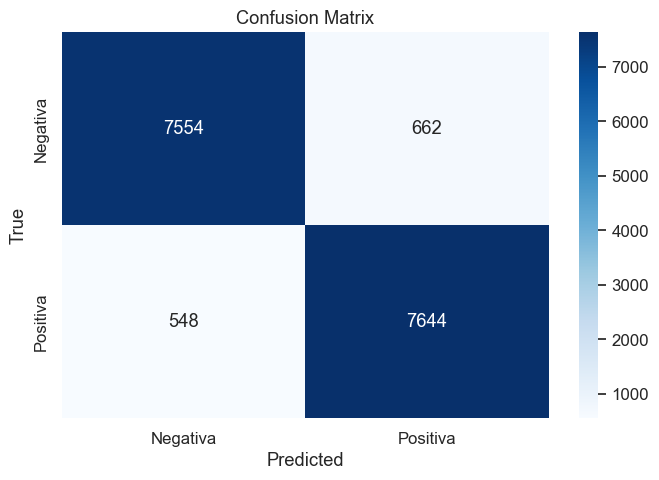

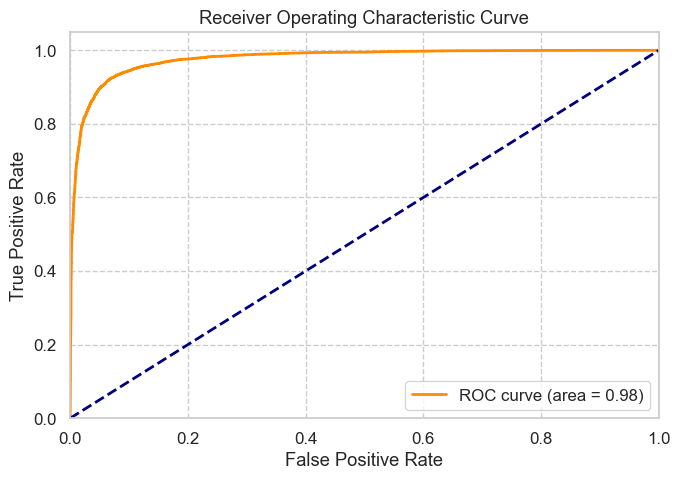

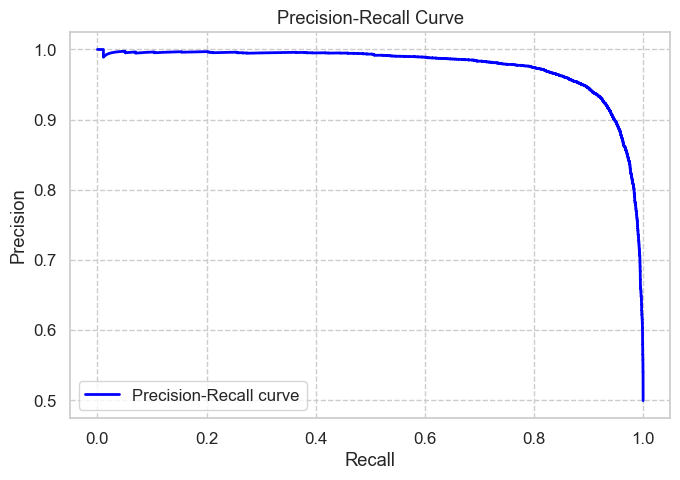

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Plotto la matrice di confusione
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Negativa', 'Positiva'], yticklabels=['Negativa', 'Positiva'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
save_fig('confusion_matrix')
plt.show()

# Calcolo e plotto la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
save_fig('roc_auc')
plt.show()

# Calcolo e plotto la Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probabilities)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
save_fig('precision_recall')
plt.show()


#### SIMULAZIONE PREDIZIONE SENTIMENT DA REVIEW DI PRODOTTI SCELTI A CASO SU AMAZON

In [11]:
from clean_text_script import clean_text

def predict_review(model, review):
    review_seq = tokenizer.texts_to_sequences([review])
    review_pad = pad_sequences(review_seq, maxlen=128, padding='post')
    probability = model.predict(review_pad)
    return 'Positiva' if probability[0][0] > 0.5 else 'Negativa'


reviews = [
     # Una recensione presa a caso da amazon americano con 4 stelle (e quindi sentiment positivo)
     # Non è subito chiaro che il sentiment fosse positivo, ma il modello l'ha predetto correttamente.
    "I normally wear a size 10, in this case, I had to re-order for size 10.5. Also, the size 10 Gravel/Lime color did not have a logo on both sides. Size 10.5 had the logo on both sides." , 
           
     #ok      
    "shoes look bigger and chunkier in person than i would like. they are comfortable though and fit nicely. supportive and comfortable. they sort of remind me of a shoe an older man would wear.", 
           
    "The shoes are really nice and look nice. 2 stars just because after throwing the box away realized they came in the wrong wide so now i have a loose wide shoes (Cant return them without the box). Be carefull when checking the wide after receiving them", 
           
    "The color tone between the two shoes is different, left shoe is more lighter than the right shoe and quality is not as I expected. Thanks",
           
    "I’ve been wearing Under Armour shoes for a little while now, having owned 3 pairs of the Charged Assert 9s. I got these and decided to go for the grey/green color. They are very comfortable, giving me solid arch support and general comfort, however the color on the website/app is a bit misleading. I’ll update with a photo when I’ve got them in front of me, but the grey shown on the app is not at all what grey the shoes actually are for me. The photo shows a dark grey but mine are very much a light grey, which was disappointing. Also the laces aren’t the same length, which is annoying but not a deal breaker, and also was the case with my other Under Armour shoes.",
           
    "I like that it is relatively cheap for $75. And can hold up to 275lbs it says. The design and details are cool. I don't like that I had to order the same chair 3 times, to get one where the bolt holes were easy to screw in fully.",
           
    "Started ripping after 3 months or so. My 11 year old has had this chair for 6 months, and this is how it looks. I find pieces of it broken off and flaking all under his desk. Really disappointing. =(",
           
    "I will use it all day every day for work and it’s super comfortable real easy to put together and prizing Lee sturdy for the great cost",
           
     "I used clay litter for the longest but it had really started to aggravate my nostrils and eyes every time i scooped or changed the box, so i switched to crystal. You dont need to get that fancy pretty litter if all youre looking for is regular crystal litter, because this works just fine. My cat adjusted to it very easily and there is virtually no dust from the crystal litter. I will say that if you dont change it soon enough the smell or cat urine gets eye wateringly strong, but thats a maintenance problem, not a litter problem. I used this with my one cat perfectly and it could probably support two or maybe three if you changed it a little earlier. However my family used this same litter with their ungodly amount of cats and scooping and changing those litterboxes made me want to throw up with how bad the smell was. The absorbed urine litter gets stuck to the bottom so whenever you change it, it almost burns your eyes. This was only the case with many cats. With my one cat it is fine as long as you change it monthly. No health issues and the smell is way better than clay. Please only use this with the minimal amount of cats. If that were my bathroom in a house full of cats, i would run away. Not to be dramatic.",
           
     # qui capiamo quanto gli umani sappiano essere illogici, anche io avrei pensato fosse una recensione negativa, però il recensore ha dato 4 stelle... 
     "Most of my cats like it, some wont use it so I still have to buy 2 brands. This is so much better than pretty litter in terms of smell, however, its very hard to clean the litter box. The dirty litter adheres to the bottom of the litter pan. There is still quite a bit of dust as well. Given the products price it is not really economical at all. I think I'm sticking with tidy cat light.",
           
     # anche in questa, l'utente ha dato 4 stelle, ma non traspare sentiment positivo... anche qui il modello ha colto bene!
     "It absorbs good but is dusty when stirred. Our cat tracks at least as much grit as with clay based litter.",
           
     # anche qui, ha dato 4 stelle, ma i lati negativi superano di gran lunga quelli positivi, lasciando intendere un sentiment negativo, che IL MODELLO HA COLTO! ma ovviamente l'umano ha dato 4 stelle.
     "Pros Less tracking than regular clay litter No smelly urine clumps to scoop No clumps at the bottom of the litter box Other than daily maintenance, there's no need to clean the litter box as frequently as with clay litter Cons There is tracking It's not scented It's not dust free there's significantly less dust but be careful when stirrin The crystals were too large to fit through my small diameter scoop however, they were too small for a larger diameter scoop. This resulted in difficulty getting the small poo clumps without discarding a lot of clean litter"
           
     "Let me start off by saying, I've owned an all black Duro for almost 2 years now and absolutely love it. but I've always wanted a steel bracelet for it and they finally came out with one. but my god this thing is cheap. it's very jingly-jangly and just cheap sounding. worst of all, it took me probably 45 minutes of tinkering and trying to find just the right improvised tool/pen/knife/staple to adjust to fit my wrist. i would have gladly paid a little more for a better bracelet. watch looks great though! the 2 marlins are so cool on the dial and case-back!",
            
      # ha dato 4 stelle, ma è ovvio che non traspare alcun sentiment positivo da questa recensione, ancora una volta il modello ha colto in pieno!
     "Actual watch looks much dull compared to the picture posted on Amazon. It is not luminescent so you cannot keep time at night. It is just a very ordinary analog quartz watch. Of course, engineering from casio would be fantastic, This watch looks cheap compared to the other castles I bought.",
           
      # La parte finale avrebbe potuto sviare il modello, ma in realtà è stato colto l'intero senso del discorso, ergo la 4 stelle positive date dall'utente si riflettono in un sentiment positivo prontamente colto dal modello!
     "Wanted an everyday watch that I can wear when doing chores and working out without worrying about banging up my more expensive watch. Also, I wanted a watch that I can wear when I start swimming again when my pool warms up. This Casio battery-operated watch fits the bill. The watch has a nice weight and the rubber band is comfortable. The watch seems to keep good time. The rotating bezel is a nice feature. The watch has the appearance of one costing a great deal more. The only reason I gave it four stars is because the date window is very small and hard to read, at least for me. All in all, though, a very nice watch for the price.",
           
     "For those interested in the green version, the actual watch is much darker than the watch pictured. The description definitely says green & green it is. I really liked the teal dial pictured. Inexpensive but well made",
           
      # ok, anche qui, l'utente da 4 stelle ma sembra che gli abbiano insultato la madre, il modello ovviamente ha colto bene che qui trattasi di sentiment sicuramete non positivo!
     "This Casio has nice massive stainless steel case and a screwdown crown. I paired mine with a NATO band, so I can't comment about the strap. However, the Lume is pretty terrible. Getting good Lume is a solved problem, but Casio is using the same outdated tech from the 80's and 90's. If you need the read the watch in the dark, forget about this watch. The date window is comparatively tiny for a huge dial. The movement feels really cheap when having to change the date. It's hard to tell how many clicks you need to pull out to do this task. Keeps good time. On the outside it almost looks like a nice Seiko diver, but nowhere near the quality."
           
      # Questo utente crede che un cavo hdmi attaccato al suo monitor possa minare la sua connessione a internet... 
      # Davvero dobbiamo condividere il pianeta con questi esseri? La buona notizia è che il sentiment è stato colto in pieno dal modello.
     "this monitor is great, easy setup and nice picture. However though, once u plugged it in using the provided HDMI cable, the internet connection got terrible. I’d unplug the monitor, it would be fine. I found something online that suggested the HDMI cable was bad, swapped it for a different one, and internet problems were gone!"
]#end_reviews

for review in reviews:
    clean_review_text = clean_text(review)
    print("Il sentiment della recensione è stato predetto:", predict_review(model, clean_review_text))

1/1 [==============================] - 0s 24ms/step
Il sentiment della recensione è stato predetto: Positiva
1/1 [==============================] - 0s 22ms/step
Il sentiment della recensione è stato predetto: Positiva
1/1 [==============================] - 0s 20ms/step
Il sentiment della recensione è stato predetto: Negativa
1/1 [==============================] - 0s 18ms/step
Il sentiment della recensione è stato predetto: Negativa
1/1 [==============================] - 0s 20ms/step
Il sentiment della recensione è stato predetto: Negativa
1/1 [==============================] - 0s 19ms/step
Il sentiment della recensione è stato predetto: Positiva
1/1 [==============================] - 0s 19ms/step
Il sentiment della recensione è stato predetto: Negativa
1/1 [==============================] - 0s 19ms/step
Il sentiment della recensione è stato predetto: Positiva
1/1 [==============================] - 0s 19ms/step
Il sentiment della recensione è stato predetto: Positiva
1/1 [==============